In [5]:
import os
import inspect

notebook_dir = os.getcwd()

os.chdir(notebook_dir)

import pandas as pd

gene_expression = pd.read_excel(notebook_dir+'/inputs/pone.0197843.s003.xlsx')

gtex = pd.read_csv(notebook_dir+'/inputs/GTEX_data_2020.gct',sep='\t',skiprows=2,index_col=0)
attributes = pd.read_excel(notebook_dir+'/inputs/Sample_attributes_v8.xlsx')

In [6]:
from sklearn.model_selection import train_test_split
from sklearn import svm

### To begin to learn how to use sklearn, I started with using GTEx data from problem 1

In [7]:
import GTExGenie as gtx

ctx_samples = gtx.tissueFilter('Brain - Frontal Cortex', gtex, attributes)
ctx_samples = ctx_samples.T

sc_samples = gtx.tissueFilter('Brain - Spinal cord', gtex, attributes)
sc_samples = sc_samples.T

In [8]:
from sklearn import datasets
from sklearn.svm import SVC

# data
X = pd.concat([ctx_samples, sc_samples])

# target
y = [1]*len(ctx_samples) + [0]*len(sc_samples)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=1)

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

# Train the classifier
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [9]:
import numpy as np

accuracy = svm_classifier.score(X_test, y_test)
print(accuracy)

0.9830508474576272


#### Apparently, frontal cortex and spinal cord have very different transcriptomic profiles. The linear SVM model was 98% accurate using only 20% of the data to train.

In [10]:
#find what the weights are
coefficients = svm_classifier.coef_

abs_coefficients = np.abs(coefficients)

normalized_abs_coefficients = abs_coefficients / np.sum(abs_coefficients)


In [11]:
ctx_sc_genes = pd.DataFrame({'Column1':X.columns.tolist(), 
                             'Column2':coefficients.T.tolist(),
                             'Column3':gtex.Description}, index = None)

ctx_sorted_genes = ctx_sc_genes.sort_values(by='Column2',ascending=False)
sc_sorted_genes = ctx_sc_genes.sort_values(by='Column2',ascending=True)

In [12]:
print(ctx_sorted_genes.head(20))

                               Column1                   Column2   Column3
Name                                                                      
ENSG00000198804.2    ENSG00000198804.2   [4.072142035748149e-05]    MT-CO1
ENSG00000225630.1    ENSG00000225630.1   [2.845738957333906e-05]  MTND2P28
ENSG00000154146.12  ENSG00000154146.12  [2.2334494227142542e-05]      NRGN
ENSG00000210082.2    ENSG00000210082.2  [1.8153653599478875e-05]   MT-RNR2
ENSG00000155980.11  ENSG00000155980.11   [1.807967769419022e-05]     KIF5A
ENSG00000248527.1    ENSG00000248527.1  [1.4529994945543982e-05]  MTATP6P1
ENSG00000132639.12  ENSG00000132639.12   [1.369461911729196e-05]    SNAP25
ENSG00000198888.2    ENSG00000198888.2   [9.827393305751612e-06]    MT-ND1
ENSG00000160014.16  ENSG00000160014.16   [8.644995292786448e-06]     CALM3
ENSG00000166165.12  ENSG00000166165.12   [8.037609303267745e-06]       CKB
ENSG00000236824.2    ENSG00000236824.2   [7.534653931170728e-06]    BCYRN1
ENSG00000198899.2    ENSG

In [13]:
print(sc_sorted_genes.head(20))

                               Column1                    Column2  Column3
Name                                                                      
ENSG00000197971.14  ENSG00000197971.14   [-6.005695439766838e-05]      MBP
ENSG00000198763.3    ENSG00000198763.3   [-5.719742163751998e-05]   MT-ND2
ENSG00000131095.12  ENSG00000131095.12   [-5.503814247819417e-05]     GFAP
ENSG00000212907.2    ENSG00000212907.2   [-5.272533299531881e-05]  MT-ND4L
ENSG00000123560.13  ENSG00000123560.13   [-4.223155491091479e-05]     PLP1
ENSG00000211459.2    ENSG00000211459.2  [-3.2076376515662977e-05]  MT-RNR1
ENSG00000198840.2    ENSG00000198840.2  [-2.6115894799433333e-05]   MT-ND3
ENSG00000205542.10  ENSG00000205542.10   [-2.449844158557114e-05]   TMSB4X
ENSG00000160307.9    ENSG00000160307.9  [-2.4077910523686735e-05]    S100B
ENSG00000160781.15  ENSG00000160781.15  [-2.1662231109219022e-05]    PAQR6
ENSG00000198786.2    ENSG00000198786.2  [-1.6936154952121475e-05]   MT-ND5
ENSG00000244734.3    ENSG

#### It seems that much of the difference between these two tissue types comes from the relative amount of white matter vs gray matter in each tissue. The top weights for SC tissue come from myelin and glia genes like MBP, GFAP, S100B. The top weight from the frontal cortex come from neuronal genes such as beta-synuclein, KIF5a, SNAP25. 

## Microarray Data

In [14]:
import pandas as pd

microarray = pd.read_excel(notebook_dir+'/inputs/GSE109597_microarray.xlsx')
microarray = microarray.T

# get BMI information for each patient
supp3 = pd.read_excel(notebook_dir+'/inputs/pone.0197843.s003.xlsx')
supp2 = pd.read_excel(notebook_dir+'/inputs/pone.0197843.s002.xlsx')

data = supp2.iloc[2:,2:-1]

#change the column names to the patient number
data.set_index(supp2.iloc[2:,0],inplace=True)
data.columns = supp2.iloc[0,2:-1].astype(int)

In [15]:
#cleaning the data, drop the row that is unlabeled
data = data.drop(data.index[5604])

In [16]:
#make a dictionary of patient_ID and associated BMI
BMI_dict = {}

for col_name in supp2.iloc[:,2:-1]:
    col_data = supp2.iloc[:,2:-1][col_name]
    patient_ID = int(col_data.iloc[0])
    BMI = col_data.iloc[1]
    BMI_dict[patient_ID] = BMI

In [17]:
#get the patient IDs and BMIs
microarray_BMIs = []
patients = microarray.index.tolist()[1:-1]
patient_list = []

for name in patients:
    patient_number = int(name.split('_')[1][2:4])
    patient_list.append(patient_number)
    microarray_BMIs.append(BMI_dict[patient_number])
    
obese_BMIs = pd.Series(microarray_BMIs) >= 30

In [18]:
#sort microarray data by BMI
temp_data = data.T
temp_data['BMI'] = microarray_BMIs
temp_data_sorted = temp_data.sort_values(by='BMI')

In [19]:
#normalize microarray data by converting to z-score
import numpy as np

temp_data_sorted_norm = temp_data_sorted.iloc[:,:-1]
for col in temp_data_sorted_norm:
    mean = np.mean(temp_data_sorted_norm.loc[:,col])
    std = np.std(temp_data_sorted_norm.loc[:,col])
    temp_data_sorted_norm.loc[:,col] = (temp_data_sorted_norm.loc[:,col] - mean) / std

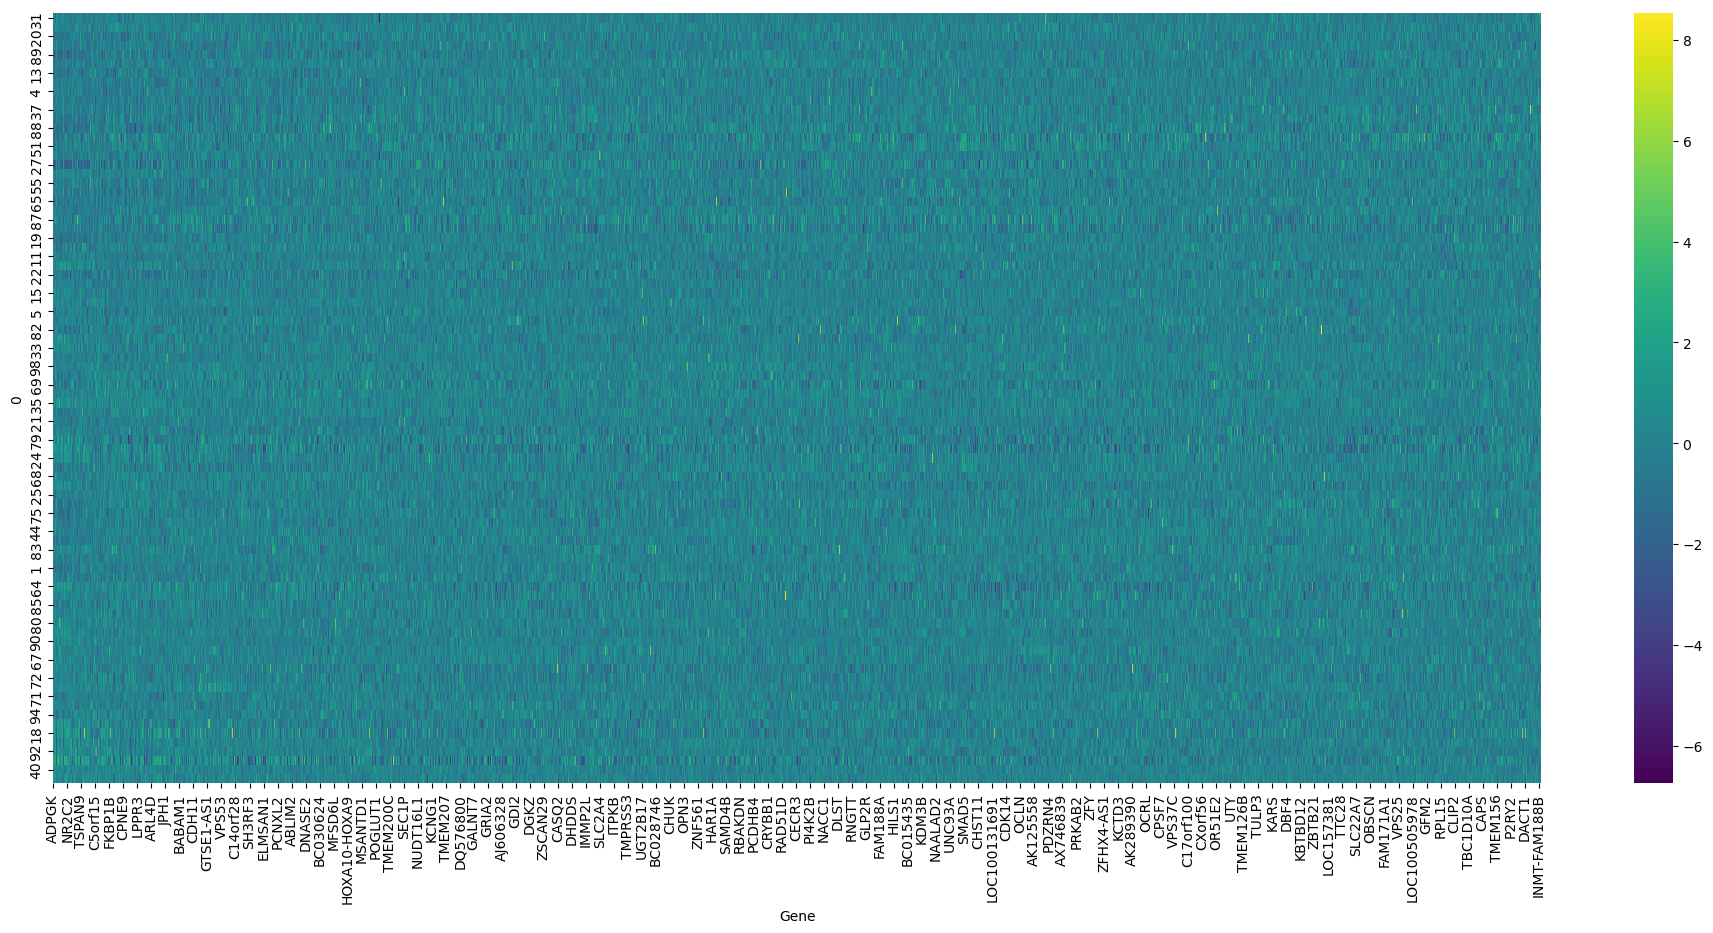

In [20]:
#plot a simple heatmap of gene expression for each patient
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(24,10))

sns.heatmap(temp_data_sorted_norm, cmap='viridis', cbar=True)

plt.show()

#### This heat map shows relative gene expression for each gene, for each patient. This is a lot of data, but does not necessary show much. I am going to sort the genes by the ones with highest differential expression in individuals with obesity.

In [21]:
#sort genes by differential expression in individuals with obesity

import statistics as stats

gene_sorted = temp_data_sorted_norm
gene_sorted['BMI'] = temp_data_sorted.BMI

obese_gene_sorted = gene_sorted[gene_sorted.BMI>=30].iloc[:,:-1]

In [22]:
obese_means = []
for col in obese_gene_sorted:
    obese_means.append(stats.mean(obese_gene_sorted[col]))

In [23]:
obese_gene_sorted = obese_gene_sorted.T
obese_gene_sorted['means'] = obese_means

In [24]:
obese_gene_sorted = obese_gene_sorted.sort_values(by='means')
sorted_index = obese_gene_sorted.index

In [25]:
#now sort all of the obesity data by sorted_index
#this will sort the genes by differentially expressed genes in obese population

In [26]:
temp_data_sorted_norm = temp_data_sorted_norm.iloc[:,:-1].T

In [27]:
temp_data_sorted_norm = temp_data_sorted_norm.reindex(sorted_index)

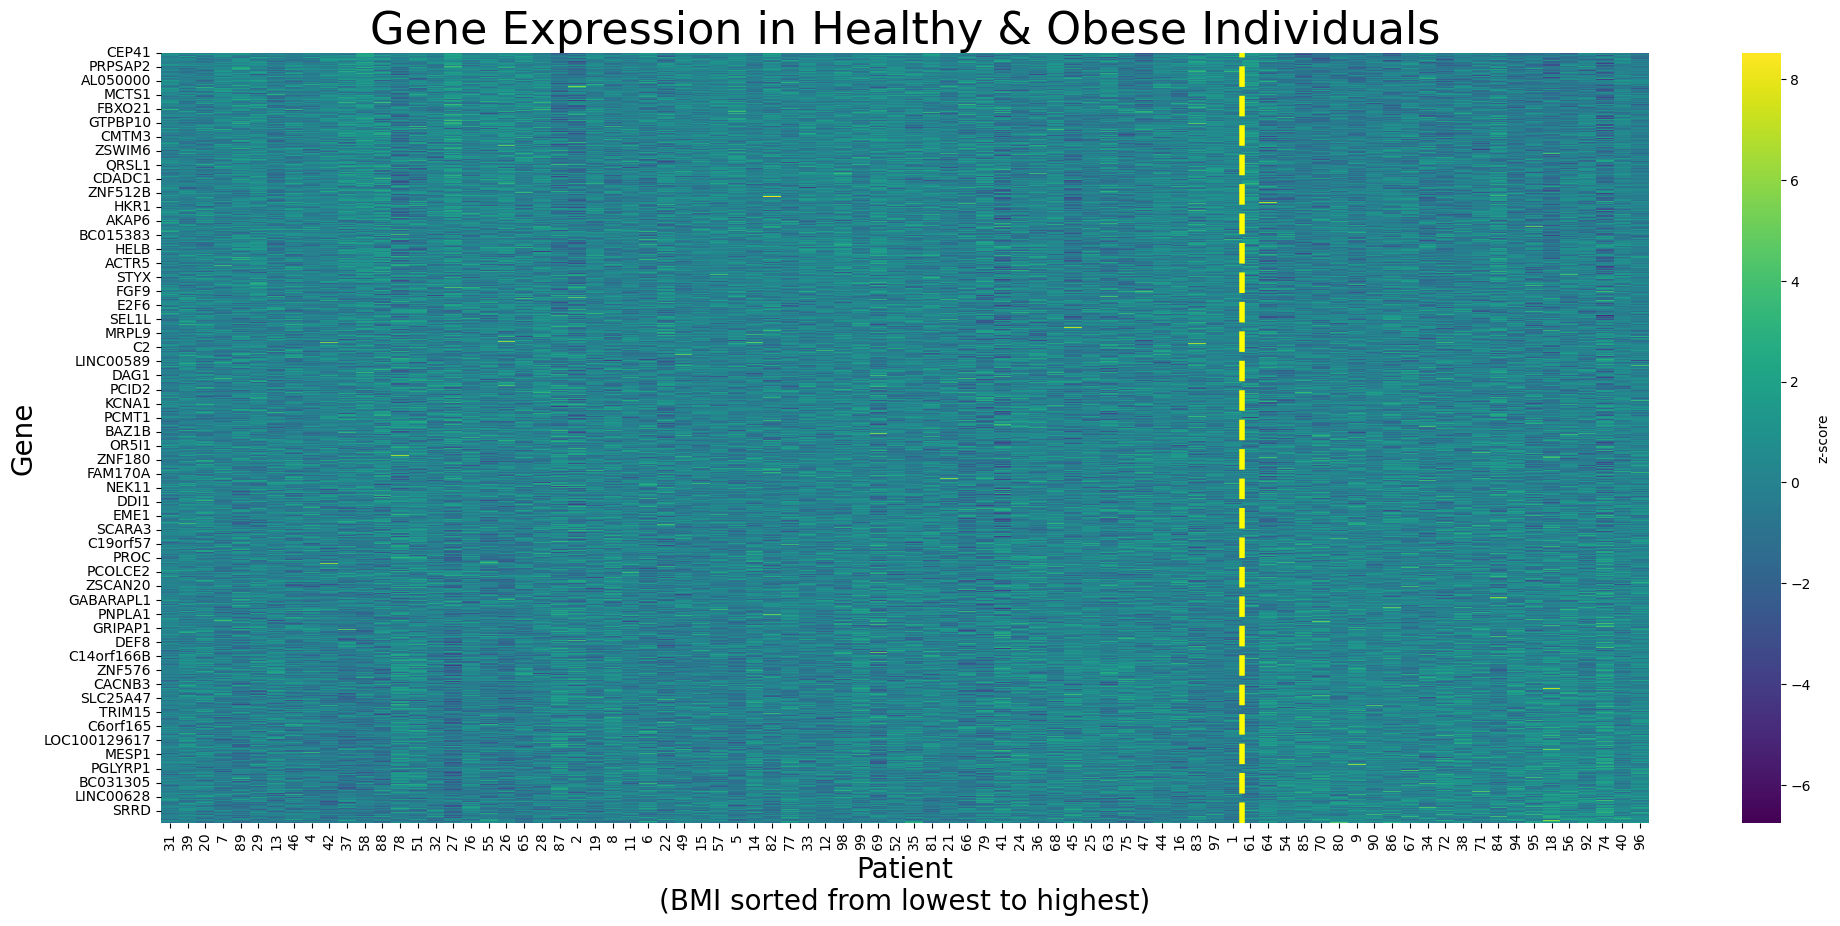

In [28]:
plt.figure(figsize=(24,10))

sns.heatmap(temp_data_sorted_norm, cmap='viridis', cbar=True, cbar_kws={'label': 'z-score'})
plt.title('Gene Expression in Healthy & Obese Individuals',fontsize=32)
plt.xlabel('Patient\n(BMI sorted from lowest to highest)',fontsize=20)
plt.ylabel('Gene',fontsize=20)
plt.axvline(x=61, color='yellow', linestyle='--', linewidth=4, label='Population Boundary')

plt.show()

#### Here we can see genes sorted from lowest to highest z-score in obese population (individuals with BMI>30 are to the right of the yellow line. Many of the genes that are highly expressed in individuals with obesity (yellow) are lowly expressed in healthy individuals (blue/purple).

In [29]:
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [30]:
# exclude gene names and IDs
X = temp_data_sorted_norm.T
X.columns = X.columns.astype(str)

# target
y = temp_data_sorted['BMI'] >= 30

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

# Train the classifier
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [31]:
accuracy = svm_classifier.score(X_test, y_test)
print(accuracy)

coefficients = svm_classifier.coef_

abs_coefficients = np.abs(coefficients)

normalized_abs_coefficients = abs_coefficients / np.sum(abs_coefficients)

0.7058823529411765


#### Using a simple SVM linear classifier on the microarray data yields an accuracy of over 70%.

In [32]:
genes_coeff = pd.DataFrame({'genes': X.columns.tolist(), 'coefficients': normalized_abs_coefficients.T.tolist()})
sorted_genes_coeff = genes_coeff.sort_values(by='coefficients',ascending=False)

In [33]:
coefficients_list = [item for sublist in sorted_genes_coeff.coefficients for item in sublist]

In [34]:
#find out how many variables are needed to capture 80% of the weights

total = 0
for idx, item in enumerate(coefficients_list):
    if total > 0.80:
        break
    else:
        total += item
        
#this loop tells me that 80% of the weights are from 6541 of the genes (about half of all the genes)

In [35]:
#run PCA on gene expression data
X = temp_data_sorted_norm.T
X.columns = X.columns.astype(str)

pca = PCA(n_components = 2)
pca_fit = pca.fit(X)
X_scores = pca_fit.transform(X)

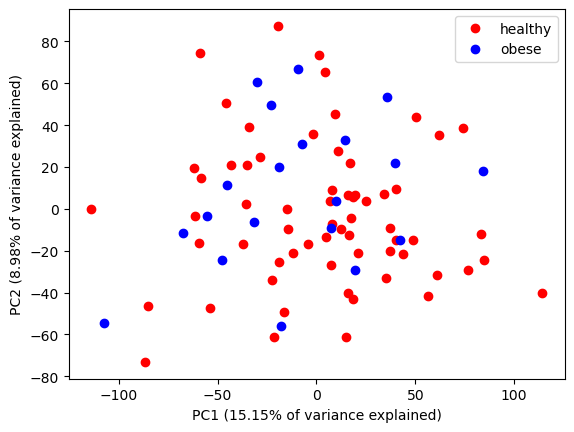

In [36]:
plt.plot(X_scores[0:64,0], X_scores[0:64,1], 'ro')
plt.plot(X_scores[64:84,0], X_scores[64:84,1], 'bo')
plt.xlabel('PC1 (15.15% of variance explained)')
plt.ylabel('PC2 (8.98% of variance explained)')
plt.legend(('healthy', 'obese'), loc = 'upper right')

#### There does not appear to be a linear separation between the two groups

In [37]:
pca_fit.explained_variance_ratio_
comps = pca_fit.components_

In [38]:
#sort each principal component features by loading values
pc1 = pd.Series(comps[0],index=temp_data_sorted_norm.index)
pc2 = pd.Series(comps[1],index=temp_data_sorted_norm.index)

pc1_sorted = np.abs(pc1).sort_values(ascending=False)
pc2_sorted = np.abs(pc2).sort_values(ascending=False)

top_1000 = pc1_sorted.iloc[0:500].index.tolist() + pc2_sorted.iloc[0:500].index.tolist()
top_1000 = [x for x in top_1000 if isinstance(x, str)]

In [39]:
#save top 1000 genes retrieved from PCA to a pickle file
import pickle
with open('/Users/patrick/Documents/CHBE194/top_1000.pickle', 'wb') as f:
    pickle.dump(top_1000, f)

In [40]:
#try to improve SVM
# exclude gene names and IDs
X = temp_data_sorted_norm.T
X.columns = X.columns.astype(str)

# target
y = temp_data_sorted['BMI'] >= 30

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

# Initialize SVM classifier
svm_classifier = SVC(kernel='poly', C=1.0)

# Train the classifier
svm_classifier.fit(X_train, y_train)

accuracy = svm_classifier.score(X_test, y_test)

#poly, rbf, and sigmoid all do not improve accuracy, compared to linear 

In [44]:
#conda install -c conda-forge lightgbm
#pip install lazypredict
import lazypredict

In [45]:
#test a bunch of models to see how they compare
from lazypredict.Supervised import LazyClassifier

X = temp_data_sorted_norm.T
X.columns = X.columns.astype(str)

# target
y = temp_data_sorted['BMI'] >= 30

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

clf = LazyClassifier(verbose=0,ignore_warnings=True,custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

 97%|█████████████████████████████████████████▌ | 28/29 [00:08<00:00,  4.54it/s]

[LightGBM] [Info] Number of positive: 9, number of negative: 41
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 242883
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 13273
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.180000 -> initscore=-1.516347
[LightGBM] [Info] Start training from score -1.516347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

100%|███████████████████████████████████████████| 29/29 [00:09<00:00,  3.21it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.76               0.70     0.70      0.75   
SGDClassifier                      0.62               0.70     0.70      0.60   
Perceptron                         0.62               0.70     0.70      0.60   
PassiveAggressiveClassifier        0.62               0.70     0.70      0.60   
LinearSVC                          0.59               0.66     0.66      0.58   
BernoulliNB                        0.74               0.66     0.66      0.71   
QuadraticDiscriminantAnalysis      0.59               0.64     0.64      0.59   
LGBMClassifier                     0.71               0.60     0.60      0.65   
RidgeClassifierCV                  0.71               0.58     0.58      0.63   
RidgeClassifier                    0.71               0.58     0.58      0.63   
XGBClassifier               

In [ ]:
#take the top 10% of genes and see how SVM model compares
top_10percent = sorted_genes_coeff.iloc[0:1327,:]
top_genes = top_10percent.genes.tolist()

X = temp_data_sorted_norm.T.loc[:,top_genes]

y = temp_data_sorted['BMI'] >= 30

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

# Train the classifier
svm_classifier.fit(X_train, y_train)

accuracy = svm_classifier.score(X_test, y_test)

#Using only 10% of the genes from the original data set, the SVM model still
#achieves 71% accuracy. 